# Human Activity Recognition using PyTorch

This is an exercise to implement a few deep learning models for recognising human activities (like walking, standing, etc) from sensor data (accelerometer and gyroscope) collected from mobile phones.

We use Jason Brownlee's tutorial (https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) as a source of inspiration and look to implement the models in PyTorch.


## The Dataset

As the tutorial suggests, we are going to use the same dataset - [Human Activity Recognition Using Smartphones Data Set, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)


The dataset contains sensor data recorded for the following activities:

    Walking
    Walking Upstairs
    Walking Downstairs
    Sitting
    Standing
    Laying

The sensor data is made up of accelerometer data (x,y and z) and gyroscope data (angular velocity), with observations recorded at 50Hz.

Please refer to Jason's article above for a detailed description of the dataset, but in summary, the data is already pre-processes and split into windows of 128 data points (2.56 seconds) with a 50% overlap between adjacent rows.

The dataset contains a bunch of engineered features, but for this exercise we will only use three sets of raw features:
    body acceleration (x,y,z)
    body gyroscope (x,y,z)
    total acceleration(x,y,z)
    
That is, 9 features for every observation of 128 data points.

The first step is to load the data and see what it looks like

In [1]:
# All the imports in one place
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import Conv1d, Conv2d, Sequential, ModuleList, BatchNorm2d
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision import transforms

from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Setting the random seed to make sure results are consistent.
# torch.manual_seed(42)

In [2]:
class HARDataLoader:
    def __init__(self, data_root):
        self.data_root = data_root
        
    def pre_operation(self, **kwargs):
        pass
    
    def post_operation(self, **kwargs):
        X = kwargs.get("X", None)
        y = kwargs.get("y", None)
        return X, y
       

    # load a single file as a numpy array
    def load_file(self, filepath):
        dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values

    # load a list of files into a 3D array of [samples, timesteps, features]
    def load_group(self, filenames, prefix=''):
        loaded = list()
        for name in filenames:
            data = self.load_file(prefix + name)
            loaded.append(data)
        
        # stack group so that features are the 3rd dimension
#         loaded = np.dstack(loaded)
#         return loaded
        return np.array(loaded).transpose(1,0,2)

    # load a dataset group, such as train or test
    def load_dataset_group(self, group):
        filepath = os.path.join(self.data_root, group, 'Inertial Signals/')
        # load all 9 files as a single array
        filenames = list()
        # total acceleration
        filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
        # body acceleration
        filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
        # body gyroscope
        filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
        # load input data
        X = self.load_group(filenames, filepath)
        # load class output
        y = self.load_file(os.path.join(self.data_root, group, 'y_'+group+'.txt'))
        return X, y

    # load the dataset, returns train and test X and y elements
    def load_dataset(self, **kwargs):
        
        train_test = kwargs.get("train_test", "train")
        
        self.pre_operation(**kwargs)
        
        # load all train
        X, y = self.load_dataset_group(train_test)
        # reshape to channel first shape
#         X = X.reshape(-1, 9, 128)
        
        # zero-offset class values
        y = y - 1
        
        X, y = self.post_operation(X=X, y=y)
        
        return X, y
    
    def load_labels(self):
        labels_file = os.path.join(self.data_root, 'activity_labels.txt')
        return list(pd.read_csv(labels_file, header=None, delim_whitespace=True)[1].array)

    def to_categorical(self, y, num_classes):
        """ 1-hot encodes a tensor """
        return np.eye(num_classes, dtype='uint8')[y]

### Test the HARDataLoader

In [167]:
dl = HARDataLoader('./UCI_HAR_Dataset')

# Load the dataset
train_X, train_y = dl.load_dataset(train_test='train') 
test_X, test_y = dl.load_dataset(train_test='test')


print("Training Data:", train_X.shape, train_y.shape)
print("Testing Data:", test_X.shape, test_y.shape)

Training Data: (7352, 9, 128) (7352, 1)
Testing Data: (2947, 9, 128) (2947, 1)


In [168]:
train_X

array([[[ 1.012817e+00,  1.022833e+00,  1.022028e+00, ...,
          1.018445e+00,  1.019372e+00,  1.021171e+00],
        [-1.232167e-01, -1.268756e-01, -1.240037e-01, ...,
         -1.240696e-01, -1.227451e-01, -1.213260e-01],
        [ 1.029341e-01,  1.056872e-01,  1.021025e-01, ...,
          1.003852e-01,  9.987355e-02,  9.498741e-02],
        ...,
        [ 3.019122e-02,  4.371071e-02,  3.568780e-02, ...,
          3.985177e-02,  3.744932e-02,  2.881781e-02],
        [ 6.601362e-02,  4.269897e-02,  7.485018e-02, ...,
          1.909445e-03, -7.982483e-05, -3.771800e-05],
        [ 2.285864e-02,  1.031572e-02,  1.324969e-02, ...,
         -2.170124e-03, -5.642633e-03, -1.446006e-03]],

       [[ 1.018851e+00,  1.022380e+00,  1.020781e+00, ...,
          1.014788e+00,  1.016499e+00,  1.017849e+00],
        [-1.239760e-01, -1.268078e-01, -1.277862e-01, ...,
         -1.290268e-01, -1.264244e-01, -1.305193e-01],
        [ 9.792958e-02,  9.935086e-02,  9.811381e-02, ...,
          9.35

In [162]:
np.array(train_X).shape

(9, 3, 4)

In [163]:
np.array(train_X).transpose(1,0,2)

array([[[1. , 1.1, 1.2, 1.3],
        [1. , 1.1, 1.2, 1.3],
        [1. , 1.1, 1.2, 1.3],
        [1. , 1.1, 1.2, 1.3],
        [1. , 1.1, 1.2, 1.3],
        [1. , 1.1, 1.2, 1.3],
        [1. , 1.1, 1.2, 1.3],
        [1. , 1.1, 1.2, 1.3],
        [1. , 1.1, 1.2, 1.3]],

       [[2. , 2.1, 2.2, 2.3],
        [2. , 2.1, 2.2, 2.3],
        [2. , 2.1, 2.2, 2.3],
        [2. , 2.1, 2.2, 2.3],
        [2. , 2.1, 2.2, 2.3],
        [2. , 2.1, 2.2, 2.3],
        [2. , 2.1, 2.2, 2.3],
        [2. , 2.1, 2.2, 2.3],
        [2. , 2.1, 2.2, 2.3]],

       [[3. , 3.1, 3.2, 3.3],
        [3. , 3.1, 3.2, 3.3],
        [3. , 3.1, 3.2, 3.3],
        [3. , 3.1, 3.2, 3.3],
        [3. , 3.1, 3.2, 3.3],
        [3. , 3.1, 3.2, 3.3],
        [3. , 3.1, 3.2, 3.3],
        [3. , 3.1, 3.2, 3.3],
        [3. , 3.1, 3.2, 3.3]]])

In [151]:
np.dstack(train_X).reshape(-1,9,4)

array([[[1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. ],
        [1. , 1.1, 1.1, 1.1],
        [1.1, 1.1, 1.1, 1.1],
        [1.1, 1.1, 1.2, 1.2],
        [1.2, 1.2, 1.2, 1.2],
        [1.2, 1.2, 1.2, 1.3],
        [1.3, 1.3, 1.3, 1.3],
        [1.3, 1.3, 1.3, 1.3]],

       [[2. , 2. , 2. , 2. ],
        [2. , 2. , 2. , 2. ],
        [2. , 2.1, 2.1, 2.1],
        [2.1, 2.1, 2.1, 2.1],
        [2.1, 2.1, 2.2, 2.2],
        [2.2, 2.2, 2.2, 2.2],
        [2.2, 2.2, 2.2, 2.3],
        [2.3, 2.3, 2.3, 2.3],
        [2.3, 2.3, 2.3, 2.3]],

       [[3. , 3. , 3. , 3. ],
        [3. , 3. , 3. , 3. ],
        [3. , 3.1, 3.1, 3.1],
        [3.1, 3.1, 3.1, 3.1],
        [3.1, 3.1, 3.2, 3.2],
        [3.2, 3.2, 3.2, 3.2],
        [3.2, 3.2, 3.2, 3.3],
        [3.3, 3.3, 3.3, 3.3],
        [3.3, 3.3, 3.3, 3.3]]])

In [136]:
train_X.reshape(-1, 9, 3)

array([[[1. , 1. , 1. ],
        [1. , 1. , 1. ],
        [1. , 1. , 1. ],
        [1.1, 1.1, 1.1],
        [1.1, 1.1, 1.1],
        [1.1, 1.1, 1.1],
        [1.2, 1.2, 1.2],
        [1.2, 1.2, 1.2],
        [1.2, 1.2, 1.2]],

       [[1.3, 1.3, 1.3],
        [1.3, 1.3, 1.3],
        [1.3, 1.3, 1.3],
        [2. , 2. , 2. ],
        [2. , 2. , 2. ],
        [2. , 2. , 2. ],
        [2.1, 2.1, 2.1],
        [2.1, 2.1, 2.1],
        [2.1, 2.1, 2.1]],

       [[2.2, 2.2, 2.2],
        [2.2, 2.2, 2.2],
        [2.2, 2.2, 2.2],
        [2.3, 2.3, 2.3],
        [2.3, 2.3, 2.3],
        [2.3, 2.3, 2.3],
        [3. , 3. , 3. ],
        [3. , 3. , 3. ],
        [3. , 3. , 3. ]],

       [[3.1, 3.1, 3.1],
        [3.1, 3.1, 3.1],
        [3.1, 3.1, 3.1],
        [3.2, 3.2, 3.2],
        [3.2, 3.2, 3.2],
        [3.2, 3.2, 3.2],
        [3.3, 3.3, 3.3],
        [3.3, 3.3, 3.3],
        [3.3, 3.3, 3.3]]])

## Custom Dataset for torch DataLoader
We need a custom data loader class to convert the above 
trainX, trainY and testX, testY arrays into a torch DataSet.
This is to make use of torch.DataLoader for easy loading of data in batches for training.

In [3]:
class HARDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.Transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.y[index]
        if self.Transform:
            return self.Transform(x), y
        else:
            return x, y

    def __len__(self):
        return len(self.X)

### Test the HARDataset

In [97]:
# Create torch datasets and data loaders for train and test
train_set = HARDataset(train_X, train_y)
test_set = HARDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

print("Num Training samples: ", len(train_loader.dataset))
print("Num Testing samples:", len(test_loader.dataset))


Num Training samples:  7352
Num Testing samples: 2947


In [107]:
train_X.std()

0.40216517638279337

# Training and evaluating the model

We are going to evaluate various models with various hyper-parameters.
For this, let's define a framework to make it easy for us to iterate.

Below, we define a class called `Experiment` and we create objects of this class to run our experiments.

A simple example is

```
# create a network object
net = CNN_1D_Model()

# define the configurations for the experiment
config = dict(
    repeats = 2,
    epochs_per_repeat = 50,
    lr = 0.001,
    batch_size = 32
)

# create the experiment object
experiment = Experiment(net, config)

# run the experiment.
experiment.run()

```


In [4]:
class Experiment:
    def __init__(self, net, config):
        self.net = net
        self.config = config
        self.best_predictions = torch.empty(0)
        self.actuals = torch.empty(0)
        self.best_score = 0.0
        self.labels=[]
        
        
    '''
        Function to update the config.
        Should be called by the experimenter is config needs to be 
        updated between experiment runs.
    '''
    def update_config(self, config):
        self.config = config
    
    '''
        Trains the network for n epochs and returns an accuracy score
    '''
    def train_and_evaluate(self, train_loader, test_loader):
        
        # Get all the config parameters
        net = self.net
        net.apply(self.reset_net_weights)
        lr = self.config.get("lr", 0.01)
        batch_size = self.config.get("batch_size", 32)
        epochs = self.config.get("epochs_per_repeat",10)
        seq_dim = self.config.get("seq_dim", None)
        input_dim = self.config.get("input_dim", None)
                
        # Set the network object for training
        #net = net.float()
        #net.train()
        # Create the optimiser
        optimiser = optim.Adam(net.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        train_size = len(train_loader.dataset)
        test_size = len(test_loader.dataset)

        for epoch in range(epochs):
            net.train()
            correct = 0
            for index, (X, y) in enumerate(train_loader):
                X, y = X.float(), y.long().squeeze()
                X = X.view(-1, seq_dim, input_dim)
                y_hat, logits = net(X)
                loss = loss_fn(logits, y)
                
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                #predicted = torch.argmax(y_hat.data,1)
                #correct += (predicted == y).sum()

            #acc_train = float(correct) * 100.0 / train_size
                
        # Evaluation
        net.train(False)
        predictions = torch.empty(0)
        actuals = torch.empty(0)
        with torch.no_grad():
            correct, total = 0, 0
            for X, y in test_loader:
                X, y = X.float(), y.long().squeeze()
                X = X.view(-1, seq_dim, input_dim)
                y_hat, logits = net(X)
                
                predicted = torch.argmax(y_hat.data,1)
                predictions = torch.cat((predictions.float(), predicted.float()),0) 
                actuals = torch.cat((actuals.float(), y.float()), 0)
                total += y.size(0)
#                 print(predicted)
#                 print(y)
#                 print(predicted == y)
                correct += (predicted.numpy() == y.numpy()).sum()
        accuracy = correct * 100. / test_size
        if accuracy > self.best_score:
            self.best_score = accuracy
            self.best_predictions = predictions
            self.actuals = actuals
        return accuracy.item()

    
    def reset_net_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
    
    '''
        summarize scores
    '''
    def summarize_results(self):
        m, s = np.mean(self.scores), np.std(self.scores)
        repeats = self.config.get("repeats", 10)
        print('Accuracy over {0} trials: {1:.3f}% (+/-{2:.3f})'.format(repeats, m, s))
        
        # confusion matrix for best scores
        conf_matrix = confusion_matrix(self.actuals, self.best_predictions)
        df_cm = pd.DataFrame(conf_matrix, index = self.labels, columns = self.labels)
        plt.figure(figsize = (10,7))
        plt.title('Confusion Matrix For Best Run', fontsize=20)
        sns.heatmap(df_cm, annot=True, fmt='g')
        plt.show()
        self._plot(self.scores)

    # helper function to plot scores
    def _plot(self, data):
        plt.figure(figsize = (10,7))
        sns.lineplot(range(1, len(data) + 1), data)
        
        plt.xlabel('Repeats', fontsize=14)
        plt.ylabel('Accuracy(%)', fontsize=14)
        plt.title('Test Accuracy', fontsize=20)
        plt.show()

    ''' 
        Run the experiment
    '''
    def run(self):
        
        # load data
        har_dataloader = HARDataLoader('./UCI_HAR_Dataset')
        train_X, train_y = har_dataloader.load_dataset(train_test='train') 
        test_X, test_y = har_dataloader.load_dataset(train_test='test')
        self.labels = har_dataloader.load_labels()

        # repeat experiment
        self.scores = list()
        repeats = self.config.get("repeats", 10)
        batch_size = self.config.get("batch_size", 32)
        for r in range(repeats):
            # Create the data loaders
            train_set = HARDataset(train_X, train_y)
            test_set = HARDataset(test_X, test_y)
            train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

            # train and evaluate the model
            score = self.train_and_evaluate(train_loader, test_loader)
            print('#{0}: {1:.3f}'.format(r+1, score))
            self.scores.append(score)
        # summarize results
        self.summarize_results()

In [330]:
experiment.scores[0].item()

45.80929946899414

In [287]:
experiment.actuals.int()

tensor([5, 3, 5,  ..., 0, 1, 1], dtype=torch.int32)

In [288]:
experiment.best_predictions.int()

tensor([5, 5, 5,  ..., 0, 1, 0], dtype=torch.int32)

In [289]:
conf_matrix = confusion_matrix(experiment.actuals, experiment.best_predictions)
df_cm = pd.DataFrame(conf_matrix, index = experiment.labels, columns = experiment.labels)
df_cm

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,476,0,0,0,0,20
WALKING_UPSTAIRS,12,412,0,0,0,47
WALKING_DOWNSTAIRS,17,0,0,0,0,403
SITTING,1,9,0,0,133,348
STANDING,0,0,0,0,482,50
LAYING,0,27,0,0,0,510


In [120]:
actuals =     np.array([0,0,0, 1,1,1, 2,2,2])
predictions = np.array([2,0,0, 2,1,1, 1,2,2])
conf_matrix = confusion_matrix(actuals, predictions)
df_cm = pd.DataFrame(conf_matrix, index = [0,1,2], columns = [0,1,2])
df_cm

,0,1,2
0,2,0,1
1,0,2,1
2,0,1,2


# CNN Model 1

Let's define the first CNN model with 1D conv layers as used in the article.
The network architecture is:

`Conv1D -> Conv1D -> Dropout -> MaxPool -> FullyConnected -> FullyConnected -> Softmax`

In [5]:
class CNN_1D_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.max_pool1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=64*62, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=6)
        
    def forward(self, x):
        # expected shape of x is (1, 9, 128)
        x = self.conv1(x)
        x = F.relu(x)
        # shape of x now is (1, 64, 126)
        x = self.conv2(x)
        x = F.relu(x)
        # shape of x now is (1, 64, 124)
        
        # Dropout
        x = self.dropout1(x)
        # shape of x now is (1, 64, 124)
        
        # MaxPool
        x = self.max_pool1(x)
        # shape of x now is (1, 64, 62)
        
        # Flatten
        #x = torch.flatten(x)
        x = x.view(-1, 3968)
        # shape of x now is (3968)
        #print(x.shape)
        
        # Fully connected (Dense layers)
        x = self.fc1(x)
        x = F.relu(x)
        # shape of x now is (100)
        x = self.fc2(x)
        x = F.relu(x)
        # shape of x now is (6)
        
        # apply softmax
        y_hat = F.softmax(x, dim=1)
        return (y_hat, x)

In [275]:
net = CNN_1D_Model()
input = torch.rand(5,9,128)
out, logits = net(input)
print(out)
print(logits)

loss_fn = nn.CrossEntropyLoss()
y = torch.Tensor([1,1,1,1,1])
print(y)
loss_fn(out,y.long())


tensor([[0.1632, 0.1754, 0.1632, 0.1632, 0.1716, 0.1632],
        [0.1641, 0.1641, 0.1641, 0.1678, 0.1758, 0.1641],
        [0.1630, 0.1712, 0.1630, 0.1672, 0.1726, 0.1630],
        [0.1635, 0.1677, 0.1635, 0.1669, 0.1750, 0.1635],
        [0.1648, 0.1707, 0.1648, 0.1648, 0.1702, 0.1648]],
       grad_fn=<SoftmaxBackward>)
tensor([[0.0000, 0.0720, 0.0000, 0.0000, 0.0500, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0227, 0.0690, 0.0000],
        [0.0000, 0.0487, 0.0000, 0.0251, 0.0572, 0.0000],
        [0.0000, 0.0255, 0.0000, 0.0205, 0.0684, 0.0000],
        [0.0000, 0.0354, 0.0000, 0.0000, 0.0325, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([1., 1., 1., 1., 1.])


tensor(1.7886, grad_fn=<NllLossBackward>)

In [311]:
print(torch.argmax(out.data,1))
y==torch.argmax(out.data,1)

tensor([1, 4, 4, 4, 1])


tensor([ True, False, False, False,  True])

#1: 75.738
Accuracy over 1 trials: 75.738% (+/-0.000)


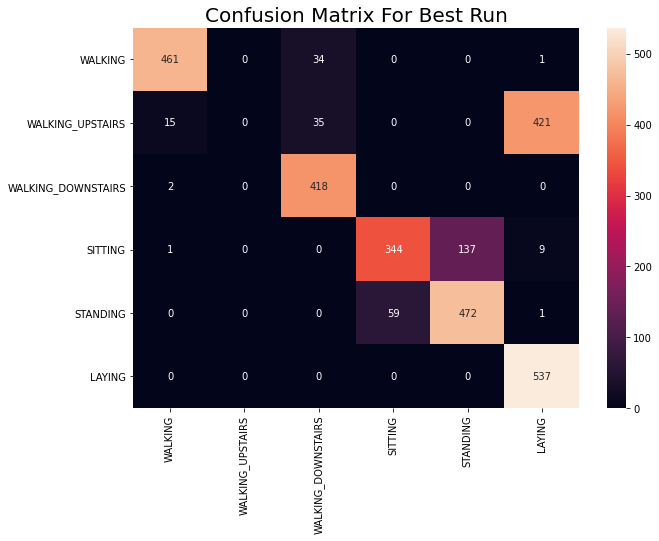

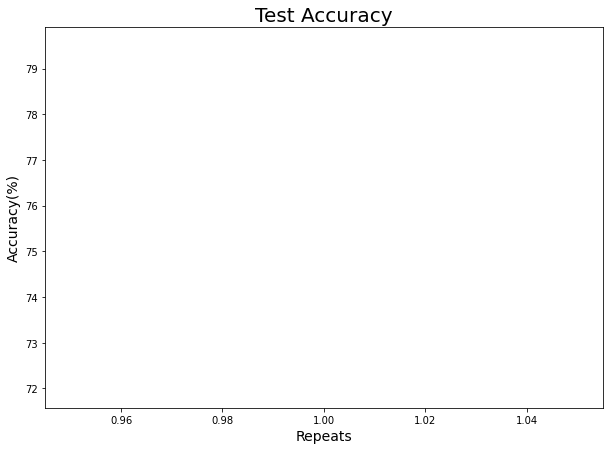

In [6]:
net = CNN_1D_Model()
config = dict(
    repeats = 1,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    seq_dim = 9, # channels
    input_dim = 128
)
experiment = Experiment(net, config)
experiment.run()

In [324]:
experiment.scores

[tensor(45.8093)]

### Update the model with kernel size 5

In [ ]:
class CNN_1D_Model_Kernel5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=64, kernel_size=5, stride=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, stride=1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.max_pool1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=64*60, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=6)
        
    def forward(self, x):
        # expected shape of x is (1, 9, 128)
        x = self.conv1(x)
        x = F.relu(x)
        
        # shape of x now is (1, 64, 124)
        x = self.conv2(x)
        x = F.relu(x)
        # shape of x now is (1, 64, 120)
        
        # Dropout
        x = self.dropout1(x)
        # shape of x now is (1, 64, 120)
        
        # MaxPool
        x = self.max_pool1(x)
        # shape of x now is (1, 64, 60)
        
        # Flatten
        #x = torch.flatten(x)
        x = x.view(-1, 3840)
        # shape of x now is (3840)
        #print(x.shape)
        
        # Fully connected (Dense layers)
        x = self.fc1(x)
        x = F.relu(x)
        # shape of x now is (100)
        x = self.fc2(x)
        x = F.relu(x)
        # shape of x now is (6)
        
        # apply softmax
        y_hat = F.softmax(x, dim=1)
        return y_hat

In [ ]:
net = CNN_1D_Model_Kernel5()
config = dict(
    repeats = 10,
    epochs_per_repeat = 50,
    lr = 0.001,
    batch_size = 32,
    seq_dim = 9, # channels
    input_dim = 128
)
experiment = Experiment(net, config)
experiment.run()

# LSTM Model

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

#1: 87.852
Accuracy over 1 trials: 87.852% (+/-0.000)


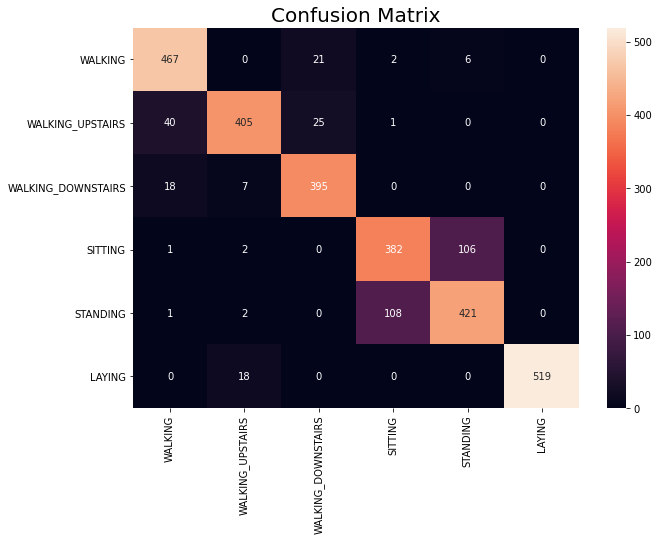

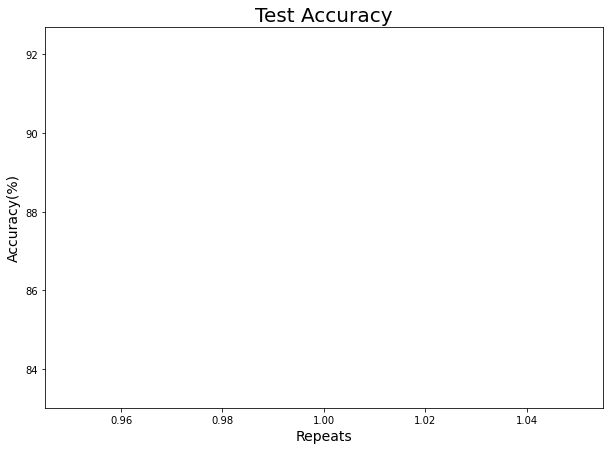

In [20]:
input_dim = 9
hidden_dim = 100
layer_dim = 1
output_dim = 6

net = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

config = dict(
    repeats = 1,
    epochs_per_repeat = 5,
    lr = 0.01,
    batch_size = 32,
    seq_dim = 128, # number of timesteps in the input
    input_dim = input_dim # number of rows in the input
)
experiment = Experiment(net, config)
experiment.run()

In [91]:
dl = HARDataLoader('./UCI_HAR_Dataset')

# Load the dataset
train_X, train_y = dl.load_dataset(train_test='train') 
test_X, test_y = dl.load_dataset(train_test='test')


In [96]:
np.histogram(train_y, bins=[0,1,2,3,4,5,6])

(array([1226, 1073,  986, 1286, 1374, 1407]), array([0, 1, 2, 3, 4, 5, 6]))

(array([1226., 1073.,  986., 1286., 1374., 1407.]),
 array([1, 2, 3, 4, 5, 6, 7]),
 <a list of 6 Patch objects>)

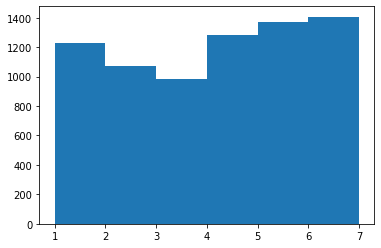

In [82]:
plt.hist(df_y[0], rwidth=2, bins=[1,2,3,4,5,6,7], range=(1,6))

In [57]:
df_y = pd.read_csv('/home/reg/Reg-Dev/workshop/human_activity_recognition/UCI_HAR_Dataset/train/y_train.txt', header=None, delim_whitespace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25f21fc080>]],
      dtype=object)

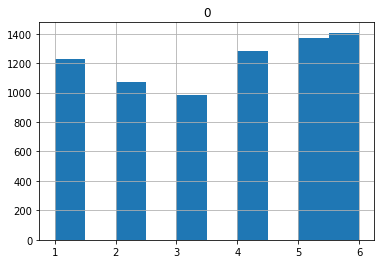

In [59]:
df_y.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25f1f9bbe0>]],
      dtype=object)

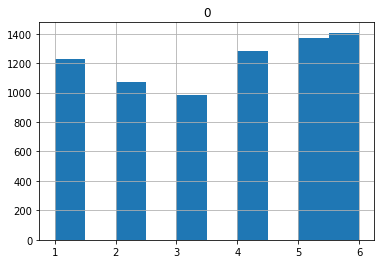

In [66]:
df_y.hist()

In [78]:
df_y = df_y.astype(int)

In [88]:
df_y[df_y[0] == 7]

,0
